In [2]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [3]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [52]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [9]:
bright_factor = 0
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 0, "config.use_testset": True}, order="-summary_metrics.test_acc")

runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0, "config.normtype_detach": 1,
                                                            "config.excitation_training": 1, "config.layer_norm": None, "config.feedback_alignment":0, "config.use_testset": True}, order="-summary_metrics.test_acc")

In [10]:
print(len(runs_dict["runs_homeostasis"]))

30


30


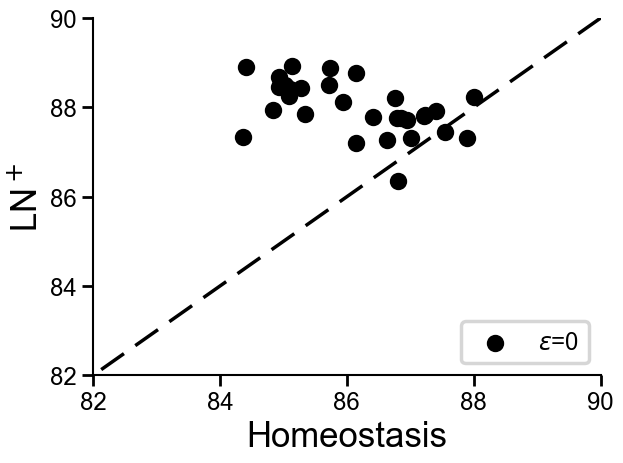

In [13]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

list_line = range(100)

label_flag = True
for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann_layernorm"][top].summary['test_acc']
    for rn in runs_dict["runs_homeostasis"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann_layernorm"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", label=f"$\epsilon$={bright_factor}" if label_flag else None)
            label_flag = False


print(len(runs_dict["runs_vanilla_dann_layernorm"]))
#ax.set_xlabel(f"LN$^+$")
ax.set_xlabel("Homeostasis", fontsize=25)
ax.set_ylabel("LN$^+$", fontsize=25)
#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
list_line = range(100)
ax.set_xlim(82, 90)
ax.set_ylim(82, 90)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.legend(loc='lower right')
# Set larger font sizes for the tick numbers
plt.show()


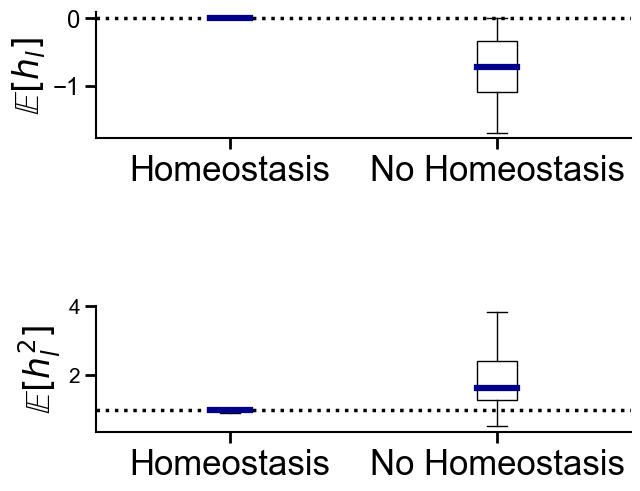

In [57]:
fig = plt.figure(layout="constrained")

plt.rcParams['figure.constrained_layout.use'] = False


gs1 = gridspec.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

mu_dann = []

mu_dann.append([run_van.summary['train_fc1_mu'] for run_van in runs_dict["runs_homeostasis"]])

mu_dann.append([run_van.summary['train_fc1_mu'] for run_van in runs_dict["runs_vanilla_dann"]])

var_dann = []

var_dann.append([run_van.summary['train_fc1_var'] for run_van in runs_dict["runs_homeostasis"]])

var_dann.append([run_van.summary['train_fc1_var'] for run_van in runs_dict["runs_vanilla_dann"]])


bp1 = ax1.boxplot(np.array(mu_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

median_colors = ["darkblue", 'darkblue']

# Iterate over each median line and set its color
for median, color in zip(bp1['medians'], median_colors):
    median.set_color(color)
    median.set_linewidth(4.5)  # Set thickness

bp2 = ax2.boxplot(np.array(var_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

median_colors = ["darkblue", 'darkblue']

# Iterate over each median line and set its color
for median, color in zip(bp2['medians'], median_colors):
    median.set_color(color)
    median.set_linewidth(4.5)  # Set thickness

# Create custom x-axis tick labels
custom_xticks = ["Homeostasis", "No Homeostasis"]
ax1.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax1.set_xticklabels(custom_xticks, fontsize=25)
ax1.axhline(y=0, color='black', linestyle='dotted')
ax2.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax2.set_xticklabels(custom_xticks, fontsize=25)
ax2.axhline(y=1, color='black', linestyle='dotted')

ax1.set_ylabel('First Moment', fontsize=20)
ax1.set_ylabel('$\mathbb{E}[h_l]$', fontsize=25)
ax2.set_ylabel('Second Moment', fontsize=20)
ax2.set_ylabel('$\mathbb{E}[h^2_l]$', fontsize=25)
#ax.legend([bp3["medians"][0]], ['H'], loc='lower left')
# ax2.set_yscale('log')

# Set larger font sizes for the tick numbers
plt.yticks(fontsize=15)
# ax1.set_title("Across 100 Hparams", fontsize=20)

gs1.tight_layout(fig, rect=[0, 0, 0.5, 1.0])
plt.show()

In [22]:
history_fc0 = []
history_fc1 = []

In [23]:
for run in runs_dict["runs_homeostasis"]:
    history_fc0.append(run.history(samples=500000, keys=["output_alignment_fc0"]))
    history_fc1.append(run.history(samples=500000, keys=["output_alignment_fc1"]))

In [25]:
# Stack the underlying numpy arrays
data_fc0 = np.stack([df.values for df in history_fc0])  # shape: (5, 3, 4)
# Compute mean
history_fc0_mean = pd.DataFrame(np.mean(data_fc0, axis=0), columns=history_fc0[0].columns)
history_fc0_std = pd.DataFrame(np.std(data_fc0, axis=0), columns=history_fc0[0].columns)

# Stack the underlying numpy arrays
data_fc1 = np.stack([df.values for df in history_fc1])  # shape: (5, 3, 4)
# Compute mean
history_fc1_mean = pd.DataFrame(np.mean(data_fc1, axis=0), columns=history_fc1[0].columns)
history_fc1_std = pd.DataFrame(np.std(data_fc1, axis=0), columns=history_fc1[0].columns)


In [26]:
print(history_fc0_mean.columns)
print(history_fc1_mean.columns)

Index(['_step', 'output_alignment_fc0'], dtype='object')
Index(['_step', 'output_alignment_fc1'], dtype='object')


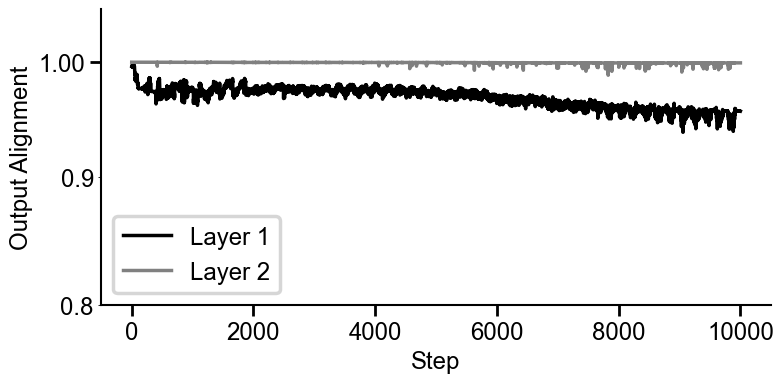

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))
output_mu_fc0 = history_fc0_mean["output_alignment_fc0"]
output_std_fc0 = history_fc0_std["output_alignment_fc0"]
ax.plot(output_mu_fc0, label="Layer 1", color='black')
# ax.fill_between(range(len(output_mu_fc0)), output_mu_fc0 - output_std_fc0, output_mu_fc0 + output_std_fc0, alpha=0.2, color='red')
output_mu_fc1 = history_fc1_mean["output_alignment_fc1"]
output_std_fc1 = history_fc1_std["output_alignment_fc1"]
ax.plot(output_mu_fc1, label="Layer 2", color='gray')
# ax.fill_between(range(len(output_mu_fc1)), output_mu_fc1 - output_std_fc1, output_mu_fc1 + output_std_fc1, alpha=0.2, color='black')
ax.set_xlabel("Step")
ax.set_ylabel("Output Alignment")
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.set_ylim(0.8,1.05)
ax.legend()
# ax.grid(True)